In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from scipy import stats
import numpy as np

In [59]:
last_month = pd.read_csv('last_month_assortment.csv')
customer_features = pd.read_csv('customer_features.csv')
original_purchase_order = pd.read_csv('original_purchase_order.csv')
product_features = pd.read_csv('product_features.csv')

## I will start by gathering data into one file

In [60]:
df = last_month.merge(customer_features, on='customer_id', how='left')

In [61]:
df = df.merge(product_features, on='product_id', how='left')

In [62]:
df.head()

,customer_id,product_id,purchased,age_bucket,is_returning_customer,favorite_genres,length,difficulty,fiction,genre
0,1000078,1730073,False,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',...",219,4,True,Drama
1,1000078,1470520,False,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',...",934,5,True,Romance
2,1000078,1861356,False,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',...",156,-1,True,Thriller
3,1000078,1240824,True,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',...",454,1,True,Classic
4,1000078,1155460,False,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',...",910,1,True,Thriller


In [63]:


# convert the string representation of list to a list
df['favorite_genres'] = df['favorite_genres'].apply(ast.literal_eval)

# proceed with one-hot encoding
mlb = MultiLabelBinarizer()
df_genres = pd.DataFrame(mlb.fit_transform(df['favorite_genres']), 
                         columns=["fav_" + genre for genre in mlb.classes_], 
                         index=df.index)

# concatenating the original df with the new 'df_genres' DataFrame
df = pd.concat([df, df_genres], axis=1)


In [64]:
dummies = pd.get_dummies(df['genre'])
dummies_age = pd.get_dummies(df['age_bucket'])
df = pd.concat([df, dummies], axis=1)
df = pd.concat([df, dummies_age], axis=1)

In [65]:
df.head()

,customer_id,product_id,purchased,age_bucket,is_returning_customer,favorite_genres,length,difficulty,fiction,genre,...,Sci-Fi,Self-Help,Thriller,0-17,18-25,26-35,36-45,46-55,56-65,66+
0,1000078,1730073,False,46-55,True,"[Classic, History, Self-Help, Romance, Thrille...",219,4,True,Drama,...,0,0,0,0,0,0,0,1,0,0
1,1000078,1470520,False,46-55,True,"[Classic, History, Self-Help, Romance, Thrille...",934,5,True,Romance,...,0,0,0,0,0,0,0,1,0,0
2,1000078,1861356,False,46-55,True,"[Classic, History, Self-Help, Romance, Thrille...",156,-1,True,Thriller,...,0,0,1,0,0,0,0,1,0,0
3,1000078,1240824,True,46-55,True,"[Classic, History, Self-Help, Romance, Thrille...",454,1,True,Classic,...,0,0,0,0,0,0,0,1,0,0
4,1000078,1155460,False,46-55,True,"[Classic, History, Self-Help, Romance, Thrille...",910,1,True,Thriller,...,0,0,1,0,0,0,0,1,0,0


/var/folders/j_/r9p377l96x53wfwmdtb_19p40000gn/T/ipykernel_55950/2901513449.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


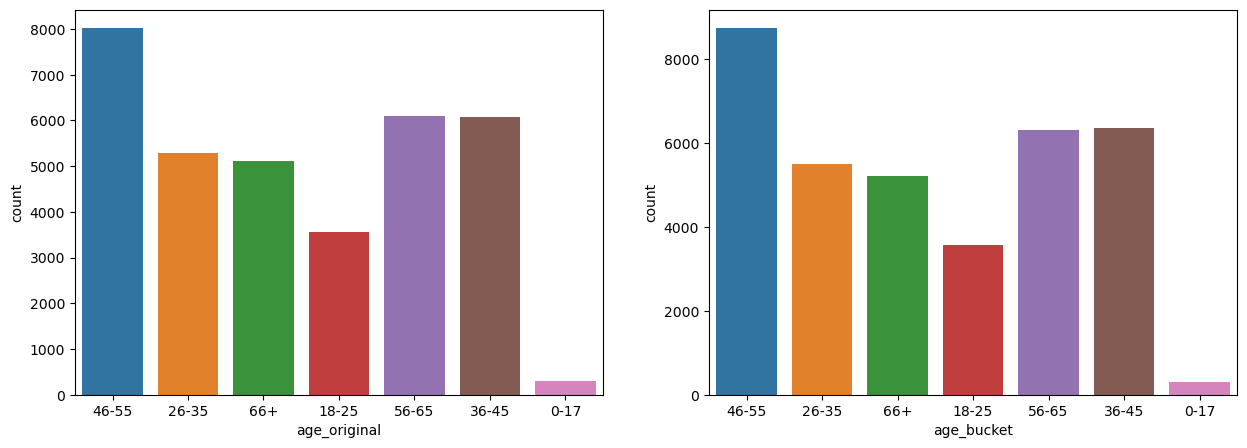

In [66]:


# Store the original age column for later comparison
df['age_original'] = df['age_bucket']

# Group by 'length', 'genre', 'difficulty' and fill missing 'age' values with the mode of each group
df['age_bucket'] = df.groupby(['length', 'genre', 'difficulty'])['age_bucket'].apply(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "Unknown"))

# Plotting the distribution before and after the operation
fig, ax =plt.subplots(1,2, figsize=(15, 5))
sns.countplot(x='age_original', data=df, ax=ax[0])
sns.countplot(x='age_bucket', data=df, ax=ax[1])
fig.show()


In [67]:
df.isna().sum()

customer_id                 0
product_id                  0
purchased                   0
age_bucket                  0
is_returning_customer       0
favorite_genres             0
length                      0
difficulty                  0
fiction                     0
genre                       0
fav_Beach-Read              0
fav_Biography               0
fav_Classic                 0
fav_Drama                   0
fav_History                 0
fav_Pop-Psychology          0
fav_Pop-Sci                 0
fav_Romance                 0
fav_Sci-Fi                  0
fav_Self-Help               0
fav_Thriller                0
Beach-Read                  0
Biography                   0
Classic                     0
Drama                       0
History                     0
Pop-Psychology              0
Pop-Sci                     0
Romance                     0
Sci-Fi                      0
Self-Help                   0
Thriller                    0
0-17                        0
18-25     

In [68]:
# First, identify the outliers by computing the z-scores.
df['z_scores'] = stats.zscore(df['length'])

# Then, compute the median length for each genre and fiction
grouped = df.groupby(['genre', 'fiction'])['length'].transform('median')

# Replace the outliers with the corresponding median of the same genre and fiction
df['length'] = np.where(df['z_scores'].abs() > 3, grouped, df['length'])

# Finally, remove the z_scores column as it's no longer needed
df = df.drop(columns=['z_scores'])

df.drop(columns=['customer_id', 'product_id', 'favorite_genres', 'genre', 'age_original', 'is_returning_customer', 'age_bucket'], inplace=True)


In [69]:
df.difficulty.unique()

array([ 4,  5, -1,  1,  2,  3])

In [72]:
df.head()

,purchased,length,difficulty,fiction,fav_Beach-Read,fav_Biography,fav_Classic,fav_Drama,fav_History,fav_Pop-Psychology,...,Sci-Fi,Self-Help,Thriller,0-17,18-25,26-35,36-45,46-55,56-65,66+
0,False,219.0,4,True,1,0,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,False,934.0,5,True,1,0,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,False,156.0,-1,True,1,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0
3,True,454.0,1,True,1,0,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
4,False,910.0,1,True,1,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0


In [73]:
boolean_columns = ['purchased', 'fiction']

for column in boolean_columns:
    df[column] = df[column].astype(int)


In [74]:
df.head()

,purchased,length,difficulty,fiction,fav_Beach-Read,fav_Biography,fav_Classic,fav_Drama,fav_History,fav_Pop-Psychology,...,Sci-Fi,Self-Help,Thriller,0-17,18-25,26-35,36-45,46-55,56-65,66+
0,0,219.0,4,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,0,934.0,5,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,0,156.0,-1,1,1,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0
3,1,454.0,1,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
4,0,910.0,1,1,1,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0


In [75]:
df['purchased'].value_counts()

0    23321
1    12679
Name: purchased, dtype: int64

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Split the DataFrame into train and test sets
X = df.drop('purchased', axis=1)  # Features (all columns except the target variable)
y = df['purchased']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6186111111111111


/Users/orabi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


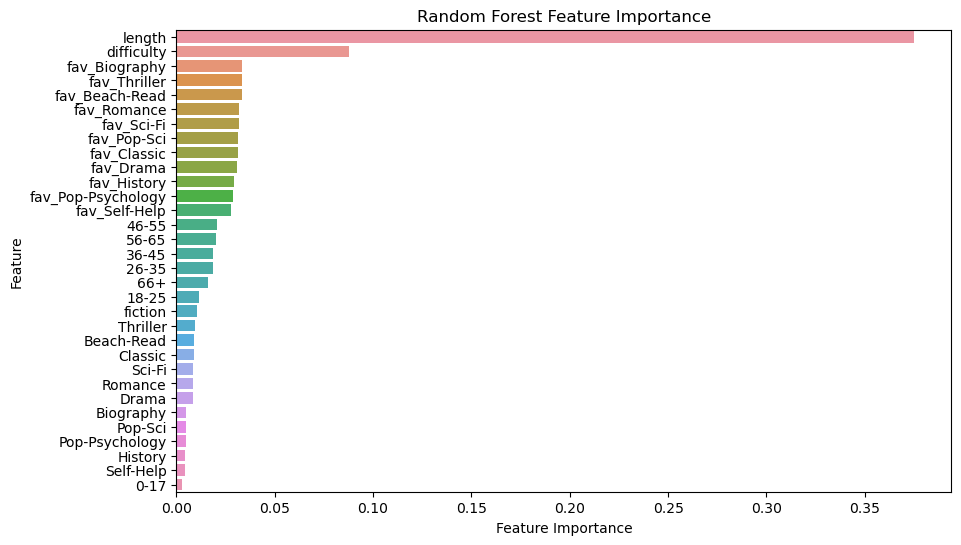

Accuracy: 0.7127777777777777


In [77]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Get feature importances from the trained model
importances = model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance scores in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()


# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [78]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Split the DataFrame into train and test sets
X = df.drop('purchased', axis=1)  # Features (all columns except the target variable)
y = df['purchased']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost classifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7313888888888889


In [82]:
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the DataFrame into train and test sets
X = df.drop('purchased', axis=1)  # Features (all columns except the target variable)
y = df['purchased']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)  # Specify the number of components to keep
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the XGBoost classifier on the reduced feature space
model = XGBClassifier()
model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_pca)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7375


# EVAL

In [191]:
next_month = pd.read_csv('next_month_assortment.csv')
purchase = pd.read_csv('next_purchase_order.csv')

In [192]:
df = next_month.merge(customer_features, on='customer_id', how='left')
df = df.merge(product_features, on='product_id', how='left')

In [193]:
df.isna().sum()

customer_id                 0
product_id                  0
age_bucket               2335
is_returning_customer       0
favorite_genres             0
length                      0
difficulty                  0
fiction                     0
genre                       0
dtype: int64

In [194]:
customer_id = df['customer_id']
product_id = df['product_id']

In [195]:


# convert the string representation of list to a list
df['favorite_genres'] = df['favorite_genres'].apply(ast.literal_eval)

# proceed with one-hot encoding
mlb = MultiLabelBinarizer()
df_genres = pd.DataFrame(mlb.fit_transform(df['favorite_genres']), 
                         columns=["fav_" + genre for genre in mlb.classes_], 
                         index=df.index)

# concatenating the original df with the new 'df_genres' DataFrame
df = pd.concat([df, df_genres], axis=1)


In [196]:
dummies = pd.get_dummies(df['genre'])
dummies_age = pd.get_dummies(df['age_bucket'])
df = pd.concat([df, dummies], axis=1)
df = pd.concat([df, dummies_age], axis=1)

In [197]:
# First, identify the outliers by computing the z-scores.
df['z_scores'] = stats.zscore(df['length'])

# Then, compute the median length for each genre and fiction
grouped = df.groupby(['genre', 'fiction'])['length'].transform('median')

# Replace the outliers with the corresponding median of the same genre and fiction
df['length'] = np.where(df['z_scores'].abs() > 3, grouped, df['length'])

# Finally, remove the z_scores column as it's no longer needed
df = df.drop(columns=['z_scores'])

df.drop(columns=['customer_id', 'product_id', 'favorite_genres', 'genre', 'is_returning_customer', 'age_bucket'], inplace=True)


In [198]:
df.isna().sum()

length                0
difficulty            0
fiction               0
fav_Beach-Read        0
fav_Biography         0
fav_Classic           0
fav_Drama             0
fav_History           0
fav_Pop-Psychology    0
fav_Pop-Sci           0
fav_Romance           0
fav_Sci-Fi            0
fav_Self-Help         0
fav_Thriller          0
Beach-Read            0
Biography             0
Classic               0
Drama                 0
History               0
Pop-Psychology        0
Pop-Sci               0
Romance               0
Sci-Fi                0
Self-Help             0
Thriller              0
0-17                  0
18-25                 0
26-35                 0
36-45                 0
46-55                 0
56-65                 0
66+                   0
dtype: int64

In [199]:
pca = PCA(n_components=2)  
X_train_pca = pca.fit_transform(df)

In [200]:
y_pred = model.predict(X_train_pca)

In [201]:
df['pred'] = y_pred

In [202]:
df.head()

,length,difficulty,fiction,fav_Beach-Read,fav_Biography,fav_Classic,fav_Drama,fav_History,fav_Pop-Psychology,fav_Pop-Sci,...,Self-Help,Thriller,0-17,18-25,26-35,36-45,46-55,56-65,66+,pred
0,266.0,1,True,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
1,749.0,2,True,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
2,278.0,1,True,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
3,268.0,2,True,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,371.0,5,False,0,1,1,0,1,1,1,...,1,0,0,0,0,0,0,1,0,0


In [203]:
df['customer_id'] = customer_id

In [204]:
df['product_id'] = product_id

In [205]:
df.head()

,length,difficulty,fiction,fav_Beach-Read,fav_Biography,fav_Classic,fav_Drama,fav_History,fav_Pop-Psychology,fav_Pop-Sci,...,0-17,18-25,26-35,36-45,46-55,56-65,66+,pred,customer_id,product_id
0,266.0,1,True,0,1,1,0,1,1,1,...,0,0,0,0,0,1,0,0,1600785,1443029
1,749.0,2,True,0,1,1,0,1,1,1,...,0,0,0,0,0,1,0,0,1600785,1164138
2,278.0,1,True,0,1,1,0,1,1,1,...,0,0,0,0,0,1,0,0,1600785,1636511
3,268.0,2,True,0,1,1,0,1,1,1,...,0,0,0,0,0,1,0,0,1600785,1832547
4,371.0,5,False,0,1,1,0,1,1,1,...,0,0,0,0,0,1,0,0,1600785,1237420


In [206]:
purchase

,product_id,quantity_purchased,cost_to_buy,retail_value
0,1479507,39,1.82,12.68
1,1681385,55,1.73,12.88
2,1771749,37,1.26,10.38
3,1605149,49,1.47,11.27
4,1861356,34,1.98,10.41
...,...,...,...,...
295,1040387,50,1.22,9.14
296,1599882,58,1.77,10.91
297,1819569,39,1.86,14.04
298,1609265,52,1.21,6.23


In [207]:
purchase.isna().sum()

product_id            0
quantity_purchased    0
cost_to_buy           0
retail_value          0
dtype: int64

In [208]:
# Count the number of predicted books sold for each product
predicted_books_sold = df[df['pred'] == 1].groupby('product_id').size().reset_index(name='sold_count')

In [209]:
predicted_books_sold[predicted_books_sold['product_id'] == 1479507]

,product_id,sold_count


In [210]:
predicted_books_sold

,product_id,sold_count
0,1004302,63
1,1007659,25
2,1014238,38
3,1014695,59
4,1017884,43
...,...,...
381,1985586,26
382,1989316,41
383,1994284,6
384,1996669,6


In [211]:
purchase

,product_id,quantity_purchased,cost_to_buy,retail_value
0,1479507,39,1.82,12.68
1,1681385,55,1.73,12.88
2,1771749,37,1.26,10.38
3,1605149,49,1.47,11.27
4,1861356,34,1.98,10.41
...,...,...,...,...
295,1040387,50,1.22,9.14
296,1599882,58,1.77,10.91
297,1819569,39,1.86,14.04
298,1609265,52,1.21,6.23


In [212]:
import pandas as pd

# Create a set of product IDs in the purchase
purchase_product_ids = set(purchase['product_id'])

# Create a set of product IDs in the predicted books sold
predicted_product_ids = set(predicted_books_sold['product_id'])

# Find the product IDs that exist in the purchase but not in the predicted books sold
missing_product_ids = purchase_product_ids - predicted_product_ids

# Count the number of missing product IDs
count_missing_product_ids = len(missing_product_ids)

# Print the count of missing product IDs
print("Number of product IDs in purchase but not in predicted_books_sold:", count_missing_product_ids)


Number of product IDs in purchase but not in predicted_books_sold: 194


In [213]:
# Merge the main DataFrame with the predicted_books_sold DataFrame
merged_df = pd.merge(purchase, predicted_books_sold, on='product_id', how='left')

In [214]:
merged_df

,product_id,quantity_purchased,cost_to_buy,retail_value,sold_count
0,1479507,39,1.82,12.68,NaN
1,1681385,55,1.73,12.88,40.0
2,1771749,37,1.26,10.38,NaN
3,1605149,49,1.47,11.27,3.0
4,1861356,34,1.98,10.41,NaN
...,...,...,...,...,...
295,1040387,50,1.22,9.14,25.0
296,1599882,58,1.77,10.91,NaN
297,1819569,39,1.86,14.04,NaN
298,1609265,52,1.21,6.23,NaN


In [215]:
merged_df.isna().sum()

product_id              0
quantity_purchased      0
cost_to_buy             0
retail_value            0
sold_count            194
dtype: int64

In [216]:

# Subtract the count of predicted books sold from the quantity_purchased column
merged_df['quantity_purchased'] = merged_df['quantity_purchased'] - merged_df['sold_count']

# Drop the unnecessary column if no longer needed
merged_df = merged_df.drop('sold_count', axis=1)

In [217]:
merged_df

,product_id,quantity_purchased,cost_to_buy,retail_value
0,1479507,NaN,1.82,12.68
1,1681385,15.0,1.73,12.88
2,1771749,NaN,1.26,10.38
3,1605149,46.0,1.47,11.27
4,1861356,NaN,1.98,10.41
...,...,...,...,...
295,1040387,25.0,1.22,9.14
296,1599882,NaN,1.77,10.91
297,1819569,NaN,1.86,14.04
298,1609265,NaN,1.21,6.23


In [219]:
merged_df.isna().sum()

product_id              0
quantity_purchased    194
cost_to_buy             0
retail_value            0
dtype: int64

In [220]:
merged_df.fillna(0, inplace=True)

In [221]:
merged_df

,product_id,quantity_purchased,cost_to_buy,retail_value
0,1479507,0.0,1.82,12.68
1,1681385,15.0,1.73,12.88
2,1771749,0.0,1.26,10.38
3,1605149,46.0,1.47,11.27
4,1861356,0.0,1.98,10.41
...,...,...,...,...
295,1040387,25.0,1.22,9.14
296,1599882,0.0,1.77,10.91
297,1819569,0.0,1.86,14.04
298,1609265,0.0,1.21,6.23


In [222]:
merged_df['profit'] = merged_df['retail_value'] * merged_df['quantity_purchased'] - merged_df['cost_to_buy']

In [226]:
merged_df.head()

,product_id,quantity_purchased,cost_to_buy,retail_value,profit
0,1479507,0.0,1.82,12.68,-1.82
1,1681385,15.0,1.73,12.88,191.47
2,1771749,0.0,1.26,10.38,-1.26
3,1605149,46.0,1.47,11.27,516.95
4,1861356,0.0,1.98,10.41,-1.98


In [224]:
merged_df['profit'].sum()

9639.359999999999

# The company will sold books and make around 9.5K profit next month